# Goal
### The aim of this simulation is to help define the requirement for PV rotational coalignment of the pupil by inferring the clocking measurement accuracy. A better coalignment precision (currently 1 deg) would allow us to reduce the thickness of the spider masks -- which in turn has two important consequences (increased throughput, improved APP performance). The requirement would then be driven by: 
- the ELT pupil rotational stability (0.1 deg), 
- the CFO-PP1 to IMG-PP1 rotational repeatability and stability (0.16 deg in the current budget), 
- and the derotator clocking control (0.06 deg).

## Imports and input parameters

In [1]:
from astropy.io import fits
import astropy.convolution as astroconv
import time
from heeps.util.img_processing import resize_img, pad_img, crop_img
from heeps.util.coord import polar_coord
import imutils
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
maskM1 = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_M1.fits')
spiders = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/SpiderShadow.fits')
nimg = 10526                # size of the high-res pupil image
phot_spiders_L = 3.5        # pixels on the spiders (for 1 inside the pupil)
phot_spiders_N = 4.3
phot_envirnt_L = 4.3        # pixels outside the pupil (for 1 inside the pupil)
phot_envirnt_N = 5.1
pupil_img_size = 39.9988    # pupil image in m
diam_max_M1 = 39.146        # max diameter of M1 in m
FWHM_L = 0.0034             # Gaussian kernel FWHM
FWHM_N = 0.0076 
nphotons_max_pix = 100000   # number of photons on the brightest pixel
ngrid = 2048                # size of the detector
npix_M1_L = 1473            # size of M1 pupil at the detector
npix_M1_N = 1548

# Definitions of functions, step by step

In [3]:
''' Step 1: Take the ELT pupil mask (outer & inner edges + spiders), and make a reasonable assumption on how bright each region would look wrt each other. Here we used the on-sky case, for which we have some estimates (Roy's input), but we could also use the WCU pupil config if we are provided with relevant information.'''
def pupil_emission(phot_envirnt, phot_spiders):
    pup = maskM1*(1 + (1 - spiders)*(phot_spiders - 1)) + (1 - maskM1)*phot_envirnt
    imshow(pup, origin=True)
    return pup

''' Step 2: Create a Gaussian kernel representative of the pupil imager resolution, with well-known FWHM values at PIL_L_band and PIL_N_band (Conchi's input).'''
def make_gaussian_kernel(fwhm, size_fwhm=0.5):
    npupil = round(fwhm/size_fwhm)
    npupil += 1 - npupil % 2 # must be odd
    x = np.arange(0, npupil, 1, float)
    y = x[:,np.newaxis]
    center = npupil // 2
    kernel = np.exp(-4*np.log(2) * ((x-center)**2 + (y-center)**2) / fwhm**2)
    imshow(kernel, origin=True)
    print('npupil=%s ;'%npupil, 'center=%s ;'%(center+1), 'fwhm=%s pixels'%round(fwhm, 2))
    return kernel

''' Step 3: Convolve our high-res model of the pupil emission with our kernel.'''
def convolve_pupil(pup, kernel, verbose=True):
    t0 = time.time()
    pup_conv = astroconv.convolve(pup, kernel, boundary='extend')
    if verbose is True:
        imshow(pup_conv, origin=True)
        print('duration=%s s'%round(time.time() - t0))
    return pup_conv

''' Step 4: Create a mock image of the pupil as seen by the pupil imager. That is, sample the resulting convolved pupil on the detector grid (2048x2048), using the appropriate pupil size relative to the grid (Conchi's input). Assume that 100,000 photons will be collected on the brightest parts of the pupil, and generate photon noise on the image.'''
def make_detector_img(pup_img, npix_M1, phot_envirnt):
    # resize to detector
    start = npix_M1*pupil_img_size/diam_max_M1
    end = ngrid
    det_img, n1, n2 = resize_to_detector(pup_img, start, end, padding=phot_envirnt)
    # rescale to max photons per pixel (100k)
    det_img *= nphotons_max_pix/phot_envirnt
    # add photon noise
    det_img += np.random.normal(0, np.sqrt(det_img))
    imshow(det_img, origin=True)
    return det_img, n1, n2
def resize_to_detector(pup_start, start, end, padding=0, precision=1e-3, stop=1e6):
    t0 = time.time()
    print('start=%s, end=%s'%(round(start, 2), end))
    scale = end/start
    size = np.array([(x, x*scale) for x in np.arange(int(start), stop) \
        if x*scale % 1 < precision \
        and bool(x%2) is bool(round(x*scale)%2)]) # x and (x*scale) must have same parity
    assert np.any(size), "couldn't find a size: relax precision or increase stop value."
    n1, n2 = size[0]
    print('n1=%s, n2=%s'%(n1, n2))
    n1 = int(round(n1))
    n2 = int(round(n2))
    pup_end = resize_img(pad_img(resize_img(pup_start, n1), n2, padding), end)
    print('duration=%s s'%round(time.time() - t0))
    return pup_end, n1, n2

''' Step 5: Examine the variation of the chi2 wrt rotation angle. That is, for various angles (e.g. 0 to 0.5 deg), rotate our pupil emission model, convolve with our kernel, sample on the detector grid (without adding noise), and measure the chi2 goodness of fit between the mock image and the model.'''
def calc_chi2(phot_envirnt, nrot=3, drot=0.1):
    chi2s = []
    for i in range(nrot+1):
        t0 = time.time()
        pup_rot = imutils.rotate(pup, angle=i*drot)
        pup_rot[pup_rot==0] = phot_envirnt
        pup_rot[rs > rext] = phot_envirnt
        pup_rot = convolve_pupil(pup_rot, kernel, verbose=False)
        pup_rot = resize_img(pad_img(resize_img(pup_rot, n1), n2, phot_envirnt), ngrid)
        pup_rot *= nphotons_max_pix/phot_envirnt
        chi2 = np.sum((det_img-pup_rot)**2/pup_rot)/(ngrid - 1)**2
        chi2s.append(chi2)
        print('clocking=%s, chi2=%s, duration=%s s'%(round(i*drot, 1), round(chi2, 2), round(time.time() - t0)))
    x = np.arange(nrot+1)*drot
    plot(x, chi2s, '-*')
    xlim(left=0)
    ylim(bottom=0)
    xlabel('clocking error(°)')
    ylabel('$\chi^2$')
    return chi2s
# external radius with margin
rext = (diam_max_M1 + pupil_img_size)/2/pupil_img_size
rs, _ = polar_coord(nimg)

# RESULTS
## <ins>L band</ins>

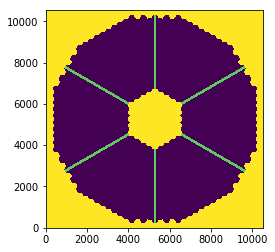

In [4]:
pup = pupil_emission(phot_envirnt_L, phot_spiders_L)
fits.writeto('pupil_emission_L.fits', pup, overwrite=True)

npupil=71 ; center=36 ; fwhm=35.03 pixels


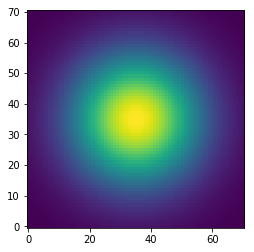

In [5]:
kernel = make_gaussian_kernel(FWHM_L*nimg*diam_max_M1/pupil_img_size)
fits.writeto('kernel_L.fits', kernel, overwrite=True)

duration=531 s


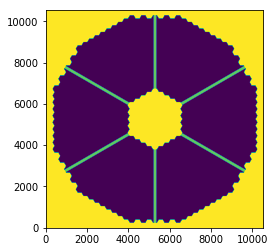

In [6]:
pup_img = convolve_pupil(pup, kernel)
fits.writeto('pup_img_L.fits', pup_img, overwrite=True)

start=1505.09, end=2048
n1=7036.0, n2=9574.000938425981
duration=8 s


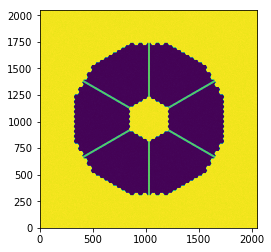

In [7]:
det_img, n1, n2 = make_detector_img(pup_img, npix_M1_L, phot_envirnt_L)
fits.writeto('det_img_L.fits', det_img, overwrite=True)

clocking=0.0, chi2=1.0, duration=537 s
clocking=0.1, chi2=18.84, duration=537 s
clocking=0.2, chi2=71.84, duration=537 s
clocking=0.3, chi2=158.15, duration=537 s


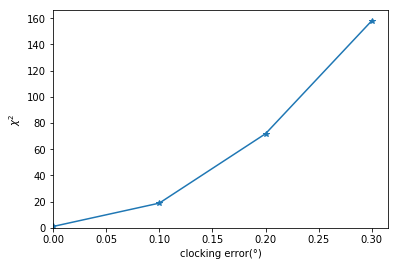

In [8]:
chi2s = calc_chi2(phot_envirnt_L, nrot=3, drot=0.1)
savefig('chi2_L.png', dpi=300, transparent=True)

## <ins>N band</ins>

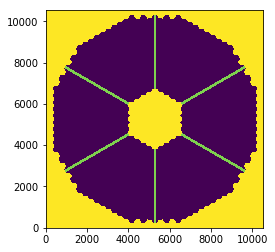

In [9]:
pup = pupil_emission(phot_envirnt_N, phot_spiders_N)
fits.writeto('pupil_emission_N.fits', pup, overwrite=True)

npupil=157 ; center=79 ; fwhm=78.29 pixels


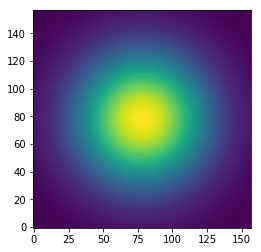

In [10]:
kernel = make_gaussian_kernel(FWHM_N*nimg*diam_max_M1/pupil_img_size)
fits.writeto('kernel_N.fits', kernel, overwrite=True)

duration=2576 s


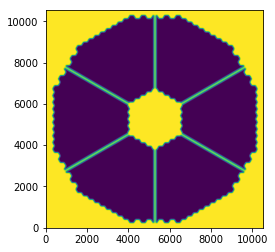

In [11]:
pup_img = convolve_pupil(pup, kernel)
fits.writeto('pup_img_N.fits', pup_img, overwrite=True)

start=1581.72, end=2048
n1=20116.0, n2=26046.000968659548
duration=72 s


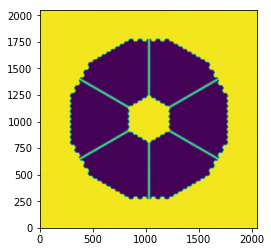

In [12]:
det_img, n1, n2 = make_detector_img(pup_img, npix_M1_N, phot_envirnt_N)
fits.writeto('det_img_N.fits', det_img, overwrite=True)

clocking=0.0, chi2=1.0, duration=2661 s
clocking=0.1, chi2=10.71, duration=2643 s
clocking=0.2, chi2=39.79, duration=2644 s
clocking=0.3, chi2=88.05, duration=2644 s


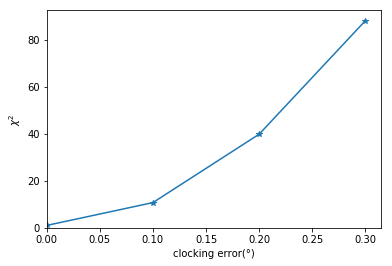

In [13]:
chi2s = calc_chi2(phot_envirnt_N, nrot=3, drot=0.1)
savefig('chi2_N.png', dpi=300, transparent=True)

# Figure with L and N bands
### We inferred that our clocking measurement accuracy will be much better than 0.1 deg (probably around 0.01 deg). To be more specific, the reduced chi2 goes from 1 for a 0 deg error to 19 at L band (resp. 11 at N band) for a 0.1 deg error on the clocking of the model.

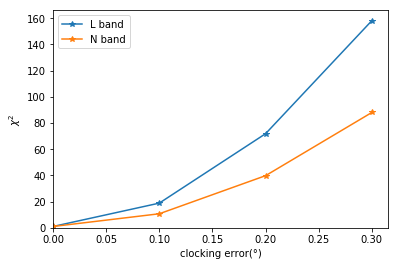

In [14]:
chi2L = [1, 18.84, 71.84, 158.16]
chi2N = [1, 10.71, 39.80, 88.06]
x = np.arange(4)*.1
plot(x, chi2L, '-*', label='L band')
plot(x, chi2N, '-*', label='N band')
legend()
xlim(left=0)
ylim(bottom=0)
xlabel('clocking error(°)')
ylabel('$\chi^2$')
savefig('chi2.png', dpi=300, transparent=True)